<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/BP_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ABP and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The output of this notebook is PPG signals with 5s segements at 125 Hz, with systolic and diastolic BP as numeric labels. The output data will be used to train a PPG_BP model in PPG_BP notebook.


The data cleaning and preprocessing is inspired by the following workflow, with some minor modification for our own application, where the order is:
1. Normalization
2. Segmentation
3. Flat line removal
4. Band-pass filter
5. Hampel filter

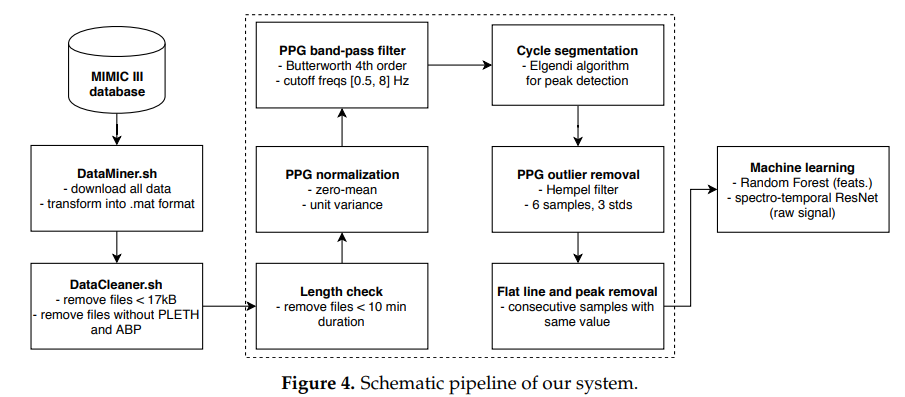

#2.Setup Environment

In [0]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
from sklearn import preprocessing
import io
import pickle
import numba
from numba import jit
import tensorflow as tf

#3.Mine ABP and PPG data from WFDB

In [0]:
hd_names = []
for name in glob.glob("D:/WFDB//matched/*/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  363716 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ABP waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'ABP' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #only extract records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ABP and PPG with more than 10min recording')

with open('D:/WFDB//matched/BP/qualified_names.pkl', "wb") as fp:
  pickle.dump(qualified_names, fp)

There are total 54440 records that have both ABP and PPG with more than 10min recording


In [0]:
def mine_data(qualified_names):
  ABP_signals = [] #create a  list to store all  ABP signals
  PPG_signals = [] #create a  list to store all  PPG signals
  n=0
  for name in qualified_names:
    record = wfdb.rdrecord(name)

    ABP_index = record.sig_name.index('ABP')
    PPG_index = record.sig_name.index('PLETH')
    ABP_sig = record.p_signal.T[ABP_index]
    PPG_sig = record.p_signal.T[PPG_index]

    if np.isnan(ABP_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
      continue
    else:
      ABP_signals.append(ABP_sig)
      PPG_signals.append(PPG_sig)
      n+=1
    
    #for every 500 samples, save to disk to release the RAM space
    if n%100 == 0:
      print("saving data No." + str(n//100))
      #save ABP data
      with open('D:/WFDB//matched/BP/ABP_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(ABP_signals, fp)
      #save PPG data
      with open('D:/WFDB//matched/BP/PPG_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(PPG_signals, fp)
      #clear up space in the list
      ABP_signals.clear()
      PPG_signals.clear()

    else:
      continue
  
  #save the last <100 ABP data
  with open('D:/WFDB//matched/BP/ABP_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(ABP_signals, fp)
  #save the last <500 PPG data
  with open('D:/WFDB//matched/BP/PPG_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(PPG_signals, fp)
  
  return None

In [0]:
mine_data(qualified_names)

#4.Process PPG and ABP raw data

In [0]:
with open('D:/WFDB//matched/BP/PPG_signals_2.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)

In [0]:
with open('D:/WFDB//matched/BP/ABP_signals_2.pkl', "rb") as fp:
  ABP_raw_signals = pickle.load(fp)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


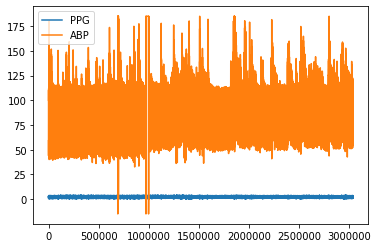

In [28]:
plt.plot(PPG_raw_signals[1],label="PPG")
plt.plot(ABP_raw_signals[1],label="ABP")
plt.legend()

##4.1 Flat line removal

To remove the flatline of a record: if 10% of the signals are made of flatline, then the entire record is removed. The flatline is defined as the change of consecutive points is smaller than a pre-defined threshold. In this notebook, the threshold has been set to 0, whereas a more reasonable value would come from histgram analysis of diff.


In [0]:
@jit(nopython=True)
def flat_line(signals,threshold = 0, percent = .15):
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = np.abs(signal_diff) <= threshold
    more = np.abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = np.sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer like me
    if i%10000 == 0:
      print("Processing on", i, "th sample")

  return clean_signals,rm_list

###4.1.1 PPG flat line removal

In [0]:
PPG_clean_signals,PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)

In [13]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 46 accepted PPG segments
There are 54 rejected PPG segements that have flat line region more than ~10%


In [0]:
#take the fist 100 samples to see the rejected segements
for i in range(len(PPG_rm_list[:50])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(PPG_raw_signals[x])

###4.1.2 ABP flat line removal

In [35]:
ABP_clean_signals,ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)

Processing on 0 th sample


In [36]:
print('There are',len(ABP_clean_signals),'accepted ABP segments')
print('There are',len(ABP_rm_list),'rejected ABP segements that have flat line region more than ~12%')

There are 77 accepted ABP segments
There are 23 rejected ABP segements that have flat line region more than ~12%


In [0]:
#take the fist 100 samples to see the rejected segements
for i in range(len(ABP_rm_list[:100])):
  x = ABP_rm_list[i]
  plt.figure()
  plt.plot(ABP_raw_signals[x])

###4.1.3 Remove flat ABP and PPG 


In [39]:
#join the two lists rm_list from ECG, and PPG_rm_list
ABP_list = pd.DataFrame(ABP_rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
total_list = ABP_list.merge(PPG_list,how="outer")
print('There are in total',len(total_list),"flat line segments in the joint list")

There are in total 65 flat line segments in the joint list


In [41]:
removal_list=total_list.values.tolist()
ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)
print('There are in total',len(ABP_cl_signals),"accpeted ABP segments")
print('There are in total',len(PPG_cl_signals),"accpeted PPG segments")

There are in total 35 accpeted ABP segments
There are in total 35 accpeted PPG segments


##4.2 Process PPG raw data
Only do normalization, bandpass and hempal on PPG signals, not on ABP, since APB's waveform will be the groundtruth for blood pressure.

###4.1.1 Normalization

In [0]:
PPG_norm_signals = [sklearn.preprocessing.scale(i) for i in PPG_cl_signals]

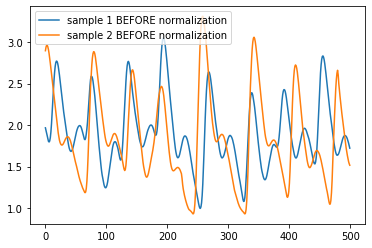

In [43]:
plt.plot(PPG_raw_signals[0][0:500],label="sample 1 BEFORE normalization")
plt.plot(PPG_raw_signals[2][0:500],label="sample 2 BEFORE normalization")
plt.legend()

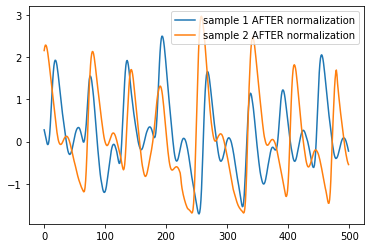

In [44]:
plt.plot(PPG_norm_signals[0][0:500],label="sample 1 AFTER normalization")
plt.plot(PPG_norm_signals[2][0:500],label="sample 2 AFTER normalization")
plt.legend()

###4.1.2 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [46]:
PPG_bf_signals = []
for i in range(len(PPG_cl_signals)):
  PPG_bf_signal =butter_bandpass_filter(PPG_cl_signals[i],0.2,8,300,order=3)
  PPG_bf_signals.append(PPG_bf_signal)
  if i%10000 == 0:
      print("Processing on", i, "th sample")
print("After band pass filtering, there are:", len(PPG_bf_signals), "PPG records")

Processing on 0 th sample
After band pass filtering, there are: 35 PPG records


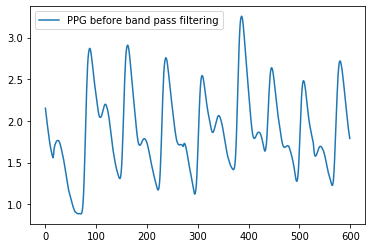

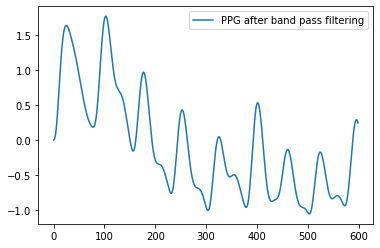

In [47]:
plt.plot(PPG_cl_signals[1][:600],label="PPG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(PPG_bf_signals[1][:600], label="PPG after band pass filtering")
plt.legend()

###4.1.3 Cycle Segmentation
Segment the PPG waveform to each heart beat cycle

In [0]:
from scipy.signals import find_peaks
def peak_segmentation(source):
  signals =[]
  for signal in source:
    valleys, _ = find_peaks(-1*signals, height = 0, distance = 60) #multiply -1 to turn this function to "find_valley"
    for i in valleys:
      

  return signals

In [0]:
from scipy.signal import find_peaks, peak_prominences, peak_widths
def flip_signals(signals):
  peaks, _ = find_peaks(signals, height=0, distance=60)
  results_half = peak_widths(signals, peaks, rel_height=0.5)

  #flip signal and calculate results_half again
  flip_peaks, _ = find_peaks(-1*signals,height=0, distance=60)
  flip_results_half = peak_widths(-1*signals, flip_peaks, rel_height=0.5)
  if np.mean(results_half[0]) > np.mean(flip_results_half[0]):
    correct_signals = signals*-1
  else:
    correct_signals = signals
  return correct_signals 

In [0]:
PPG_seg_signals = generate_segment_data(PPG_norm_signals, 3750)
print('PPG segmented signals dim:', PPG_seg_signals.shape)

PPG segmented signals dim: (83197, 3750)


In [0]:
ppg_seg_sample = sklearn.preprocessing.scale(PPG_raw_signals[0])
plt.plot(ppg_seg_sample,label="original PPG signal")
plt.legend()
plt.figure() 
plt.plot(PPG_seg_signals[0],label='30s sample PPG segement')
plt.legend()

###4.1.4 Hampel filter

The efffectiveness of hampel filter depends on how we play the two parameters: window_size and number of sigmas. 

In [0]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [0]:
PPG_hf_signals=[]
PPG_index=[]
for i in range(len(PPG_bf_signals)):
  if i%10000 == 0:
    print("hampel filering at", i+1, "th sample...")
  PPG_hf_signal, indices = hampel_filter_forloop_numba(PPG_bf_signals[i], 6)
  PPG_hf_signals.append(PPG_hf_signal)
  if indices != []:
    PPG_index.append([i,indices])
print("After Hample filtering, there are:", len(PPG_hf_signals), "PPG segments")
print("There are total", len(PPG_index),"PPG segements identified with outliers")

In [0]:
PPG_index

[]

In [0]:
plt.plot(PPG_bf_signals[1][400:505], label = "before hampel filter")
plt.plot(PPG_hf_signals[1][400:505], label = "after hampel filter")
plt.legend()

The hample filter seems like to create artificial points in ECG signals, while it has not identified outliers in PPG signals, therefore we don't use hf_signals, but instead use bf_signals for DNN

##4.3 Process ABP data

##4.4 Flat-peak removal

# 5.Construct desired data structure for deep learning


##5.1 Segmentation

In [0]:
ABP_seg_signals = generate_segment_data(ABP_norm_signals, 3750)
print('ABP segmented signals dim:', ABP_seg_signals.shape)

ECG segmented signals dim: (83197, 3750)


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


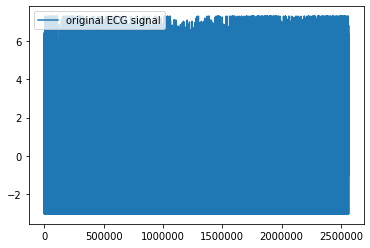

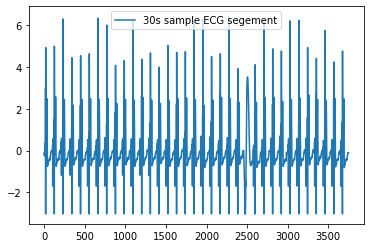

In [0]:
ABP_seg_sample = sklearn.preprocessing.scale(ABP_raw_signals[0])
plt.plot(ABP_seg_sample,label="original ABP signal")
plt.legend()
plt.figure() 
plt.plot(ABP_seg_signals[0],label='30s sample ABP segement')
plt.legend()

In [0]:
with open('D:/WFDB//matched/BP/PPG_signals_2.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)

In [0]:
with open('D:/WFDB//matched/BP/ABP_signals_2.pkl', "rb") as fp:
  ABP_raw_signals = pickle.load(fp)